https://catalog.data.gov/dataset/air-quality

Loading data, preprocessing and encoding features, training classifiers, evaluating accuracy.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import textwrap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

Verifying whether CSV contains a header by inspecting initial row.

In [2]:
dataset_path = Path("/content/Air_Quality.csv")
def detect_header(path: Path):
    first_line = path.read_text().split("\n")[0]
    tokens = first_line.split(",")
    has_alpha = any(any(char.isalpha() for char in tok) for tok in tokens)
    return has_alpha
header_exists = detect_header(dataset_path)


Loading CSV with detected header, printing dataset shape and information.

In [3]:
df = pd.read_csv(dataset_path, header=0 if header_exists else None)
print("Dataset Loaded: ")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
print(df.info())

Dataset Loaded: 
Shape: 18862 rows × 12 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18862 entries, 0 to 18861
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unique ID       18862 non-null  int64  
 1   Indicator ID    18862 non-null  int64  
 2   Name            18862 non-null  object 
 3   Measure         18862 non-null  object 
 4   Measure Info    18862 non-null  object 
 5   Geo Type Name   18862 non-null  object 
 6   Geo Join ID     18862 non-null  int64  
 7   Geo Place Name  18862 non-null  object 
 8   Time Period     18862 non-null  object 
 9   Start_Date      18862 non-null  object 
 10  Data Value      18862 non-null  float64
 11  Message         0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB
None


Displaying data preview and showing descriptive statistics for numeric columns.

In [4]:
print("Preview: ")
display(df.head(10))
print("\nDescriptive stats")
num_cols_all = df.select_dtypes(include=[np.number]).columns
display(df[num_cols_all].describe().T)

Preview: 


,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,336867,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Winter 2014-15,12/01/2014,23.97000,NaN
1,336741,375,Nitrogen dioxide (NO2),Mean,ppb,CD,107,Upper West Side (CD7),Winter 2014-15,12/01/2014,27.42000,NaN
2,550157,375,Nitrogen dioxide (NO2),Mean,ppb,CD,414,Rockaway and Broad Channel (CD14),Annual Average 2017,01/01/2017,12.55000,NaN
3,412802,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Winter 2015-16,12/01/2015,22.63000,NaN
4,412803,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Summer 2016,06/01/2016,14.00000,NaN
5,412676,375,Nitrogen dioxide (NO2),Mean,ppb,CD,107,Upper West Side (CD7),Winter 2015-16,12/01/2015,26.43000,NaN
6,412677,375,Nitrogen dioxide (NO2),Mean,ppb,CD,107,Upper West Side (CD7),Summer 2016,06/01/2016,19.10000,NaN
7,603044,375,Nitrogen dioxide (NO2),Mean,ppb,CD,314,Flatbush and Midwood (CD14),Annual Average 2018,01/01/2018,17.28000,NaN
8,412804,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Annual Average 2016,12/31/2015,18.20000,NaN
9,825832,375,Nitrogen dioxide (NO2),Mean,ppb,CD,107,Upper West Side (CD7),Winter 2021-22,12/01/2021,22.07527,NaN



Descriptive stats


,count,mean,std,min,25%,50%,75%,max
Unique ID,18862.0,452004.167533,2.629107e+05,130355.0,176073.250000,412490.50,669588.7500,878254.0
Indicator ID,18862.0,431.817888,1.139466e+02,365.0,365.000000,375.00,386.0000,661.0
Geo Join ID,18862.0,598326.193564,7.819721e+06,1.0,202.000000,303.00,404.0000,105106107.0
Data Value,18862.0,21.051580,2.356492e+01,0.0,8.742004,14.79,26.2675,424.7
Message,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Summarizing null counts, data types, and missing percentages for all columns.

In [5]:
missing = df.isna().sum()
dtype = df.dtypes
summary = pd.DataFrame({
    "dtype": dtype,
    "missing_count": missing,
    "missing_percent": (missing / len(df) * 100).round(2)
}).sort_values("missing_percent", ascending=False)

print("Missing Value Summary: ")
display(summary)

Missing Value Summary: 


,dtype,missing_count,missing_percent
Message,float64,18862,100.0
Unique ID,int64,0,0.0
Name,object,0,0.0
Indicator ID,int64,0,0.0
Measure,object,0,0.0
Measure Info,object,0,0.0
Geo Join ID,int64,0,0.0
Geo Type Name,object,0,0.0
Geo Place Name,object,0,0.0
Time Period,object,0,0.0


Dropping fully missing columns, identifying duplicates, and removing repeated rows.

In [6]:
cols_full_missing = [c for c in df.columns if df[c].isna().sum() == len(df)]
df.drop(columns=cols_full_missing, inplace=True)
print("Dropped columns :", cols_full_missing)
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

Dropped columns : ['Message']
Duplicate rows: 0


Converting start date, removing invalid entries, and extracting detailed time features.

In [7]:
df["Start_Date"] = pd.to_datetime(df["Start_Date"], format="%m/%d/%Y", errors="coerce")
df = df.dropna(subset=["Start_Date"]).reset_index(drop=True)
df["Year"] = df["Start_Date"].dt.year
df["Month"] = df["Start_Date"].dt.month
df["Day"] = df["Start_Date"].dt.day
df["Weekday"] = df["Start_Date"].dt.weekday
df["Is_Weekend"] = df["Weekday"] >= 5
display(df[["Start_Date", "Year", "Month", "Day", "Weekday", "Is_Weekend"]].head())

,Start_Date,Year,Month,Day,Weekday,Is_Weekend
0,2014-12-01,2014,12,1,0,False
1,2014-12-01,2014,12,1,0,False
2,2017-01-01,2017,1,1,6,True
3,2015-12-01,2015,12,1,1,False
4,2016-06-01,2016,6,1,2,False



Mapping time period strings to season categories through string matching.

In [8]:
def extract_season(tp: str) -> str:
    s = str(tp).lower()
    if "winter" in s:
        return "Winter"
    if "spring" in s:
        return "Spring"
    if "summer" in s:
        return "Summer"
    if "fall" in s or "autumn" in s:
        return "Fall"
    return "Unknown"
df["Season"] = df["Time Period"].apply(extract_season)
display(df[["Time Period", "Season"]].head(10))

,Time Period,Season
0,Winter 2014-15,Winter
1,Winter 2014-15,Winter
2,Annual Average 2017,Unknown
3,Winter 2015-16,Winter
4,Summer 2016,Summer
5,Winter 2015-16,Winter
6,Summer 2016,Summer
7,Annual Average 2018,Unknown
8,Annual Average 2016,Unknown
9,Winter 2021-22,Winter


Visualizing air quality values distribution using histogram and KDE curve.

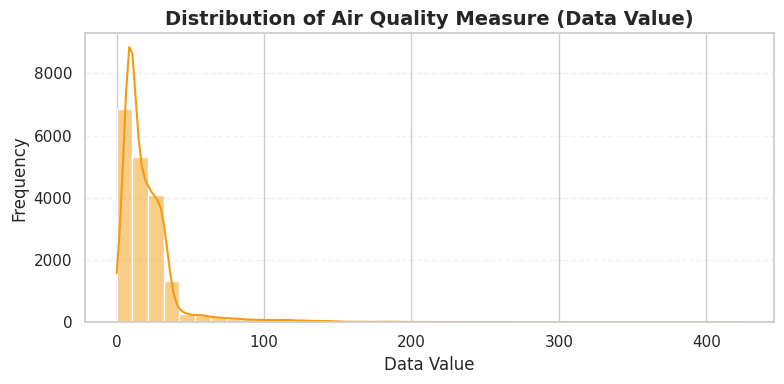

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(
    df["Data Value"],
    bins=40,
    kde=True,
    color="#f39c12"
)
plt.title("Distribution of Air Quality Measure (Data Value)", fontsize=14, weight="bold")
plt.xlabel("Data Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Comparing average air quality levels across geographic types using bar plot.

In [14]:
geo_type_mean = (
    df.groupby("Geo Type Name")["Data Value"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)
geo_type_mean.columns = ["Geo Type Name", "Mean Data Value"]
custom_colors = [
    "#6A4C93", "#8E63C5", "#A57BE2", "#C7A5F7", "#EBD8FF"
]
fig = px.pie(
    geo_type_mean,
    names="Geo Type Name",
    values="Mean Data Value",
    color="Geo Type Name",
    color_discrete_sequence=custom_colors,
    hole=0.35,
)
fig.update_traces(
    textposition="inside",
    textinfo="percent+label",
    hovertemplate="<b>%{label}</b><br>Mean Value: %{value:.2f}<extra></extra>",
    pull=[0.1] + [0]*(len(geo_type_mean)-1)
)
fig.update_layout(
    title_text="Mean Air Pollution by Geo Type",
    title_x=0.5,
    font=dict(size=14),
    showlegend=False,
    margin=dict(t=80, b=40, l=40, r=40)
)
fig.show()

Plotting highest average pollution levels across places using top-10 bar graph.

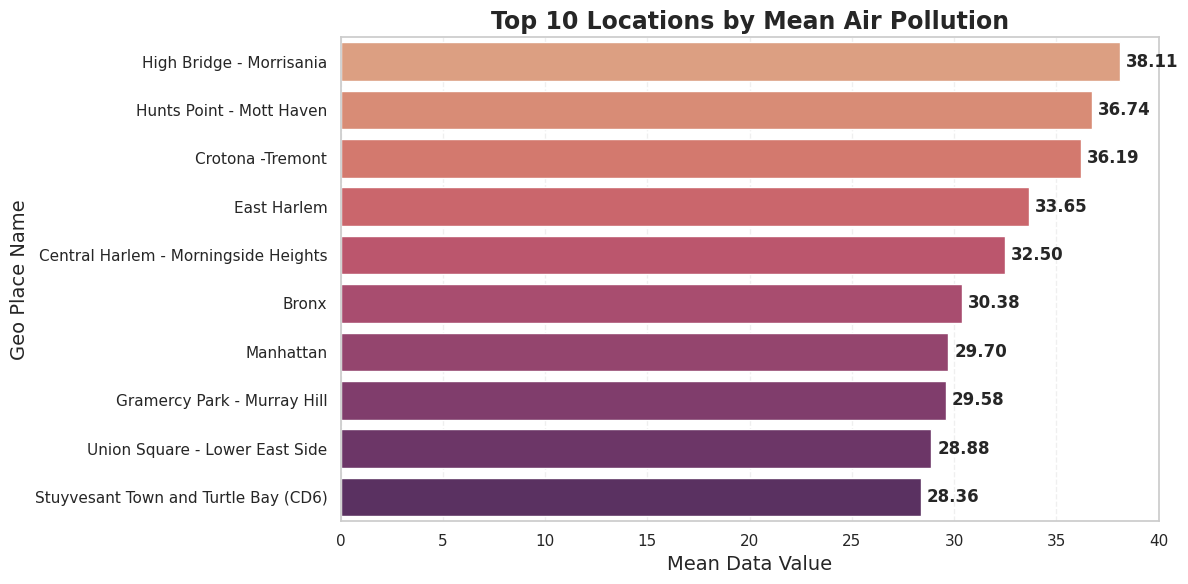

In [15]:
geo_place_mean = (
    df.groupby("Geo Place Name")["Data Value"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)
plt.figure(figsize=(12,6))
colors = sns.color_palette("flare", n_colors=10)
ax = sns.barplot(
    x=geo_place_mean.values,
    y=geo_place_mean.index,
    palette=colors
)
for i, v in enumerate(geo_place_mean.values):
    ax.text(
        v + 0.3,
        i,
        f"{v:.2f}",
        va='center',
        fontsize=12,
        fontweight='bold'
    )
plt.title("Top 10 Locations by Mean Air Pollution", fontsize=17, weight="bold")
plt.xlabel("Mean Data Value", fontsize=14)
plt.ylabel("Geo Place Name", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Visualizing mean air pollution across years using a line trend chart.

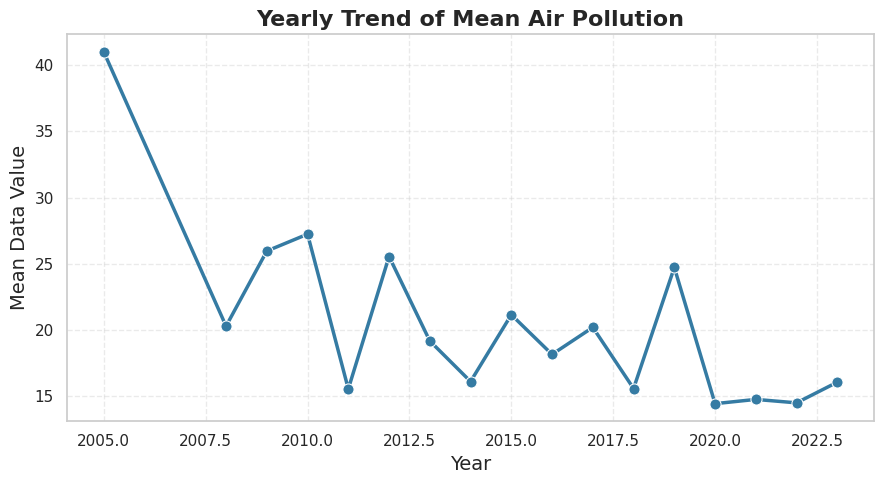

In [16]:
yearly_trend = df.groupby("Year")["Data Value"].mean()
plt.figure(figsize=(9,5))
sns.lineplot(
    x=yearly_trend.index,
    y=yearly_trend.values,
    marker="o",
    linewidth=2.5,
    markersize=8,
    color=sns.color_palette("mako", 1)[0]
)
plt.title("Yearly Trend of Mean Air Pollution", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Data Value", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Computing numeric correlations and visualizing feature relationships using a heatmap.

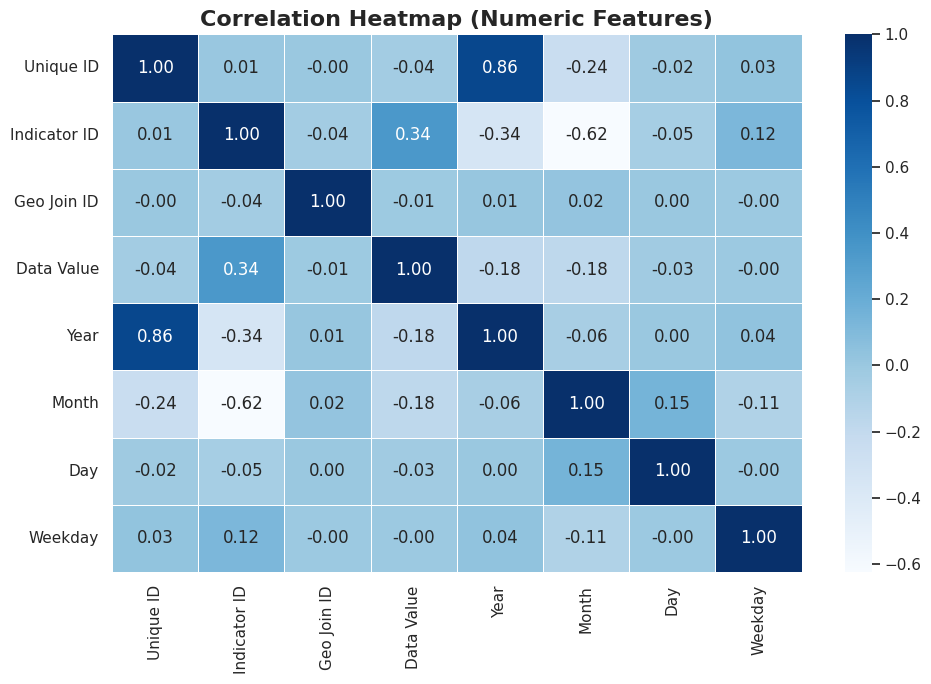

In [17]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    annot_kws={"size": 12},
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

Formatting pollutant labels neatly and comparing pollution levels through box plot.

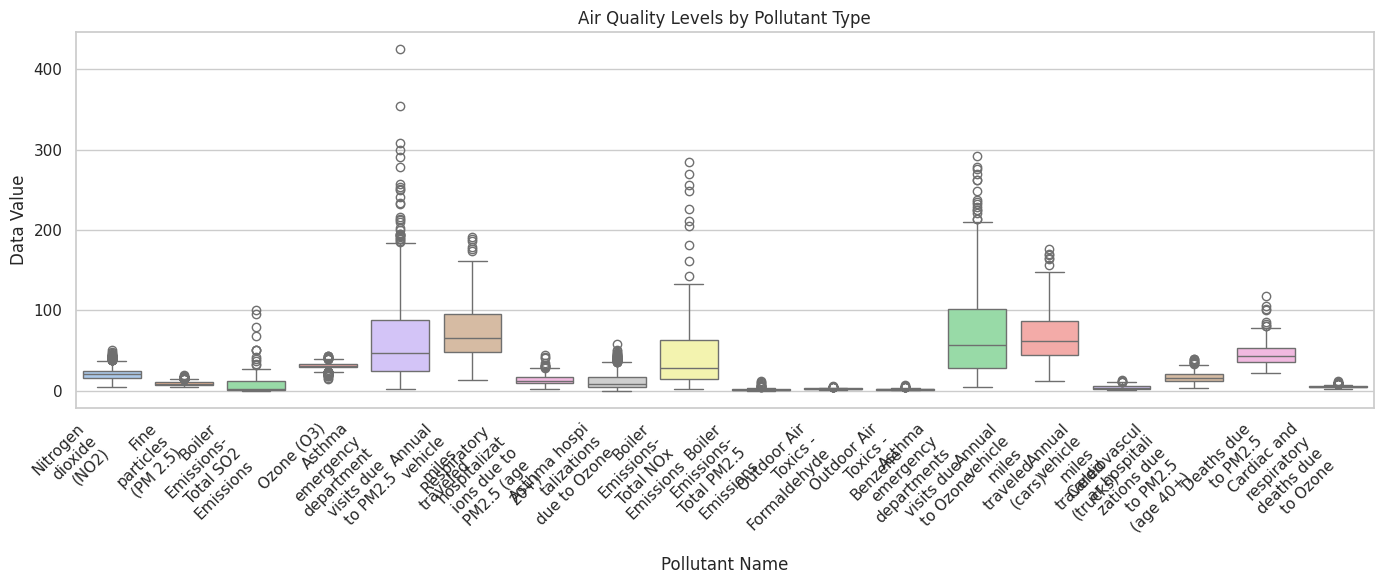

In [18]:
df["Name_wrapped"] = df["Name"].apply(lambda x: "\n".join(textwrap.wrap(str(x), 12)))
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="Name_wrapped",
    y="Data Value",
    palette="pastel"
)
plt.xticks(rotation=45, ha="right")
plt.title("Air Quality Levels by Pollutant Type")
plt.xlabel("Pollutant Name")
plt.tight_layout()
plt.show()

Capping outliers using IQR method and adjusting values within limits.

In [19]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)
df["Data Value"] = cap_outliers(df["Data Value"])
df["Data Value"] = df.groupby("Name")["Data Value"].transform(cap_outliers)


Visualizing cleaned pollutant data with boxplot after outlier capping.


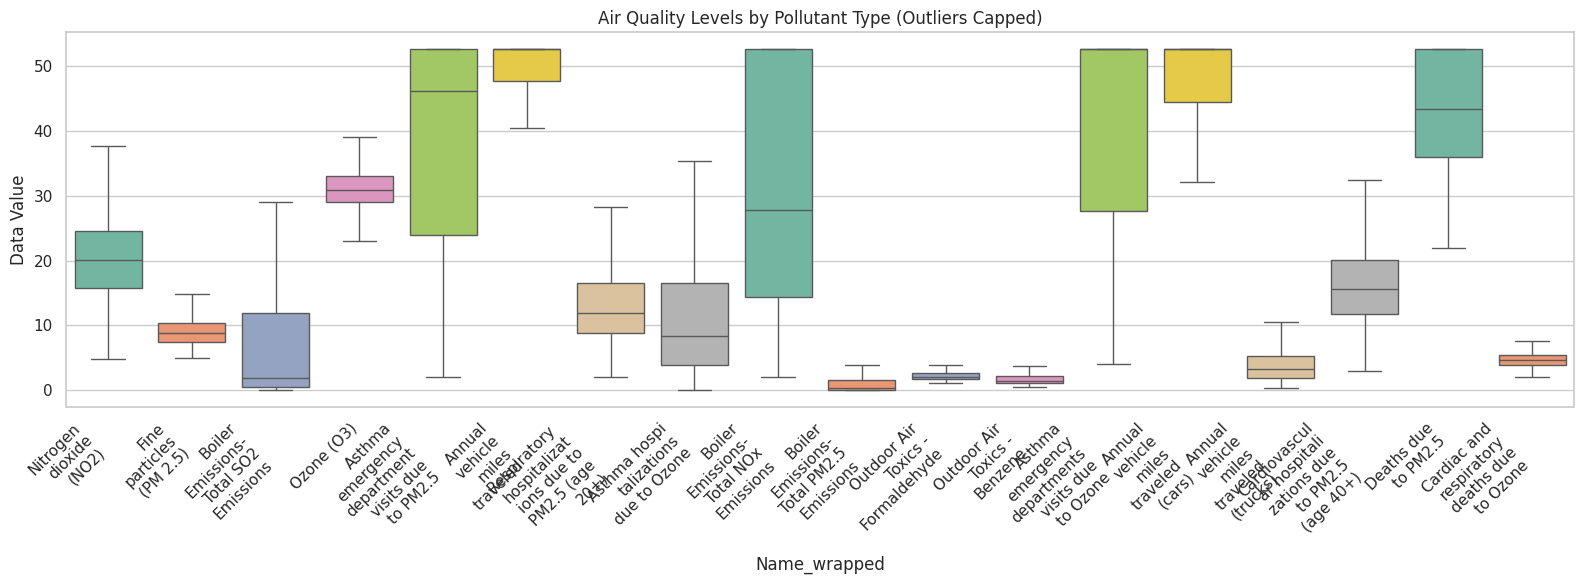

In [20]:
plt.figure(figsize=(16,6))
sns.boxplot(
    data=df,
    x="Name_wrapped",
    y="Data Value",
    palette="Set2"
)
plt.xticks(rotation=45, ha="right")
plt.title("Air Quality Levels by Pollutant Type (Outliers Capped)")
plt.tight_layout()
plt.show()

Creating pollution classes using quantiles and plotting their frequency counts.

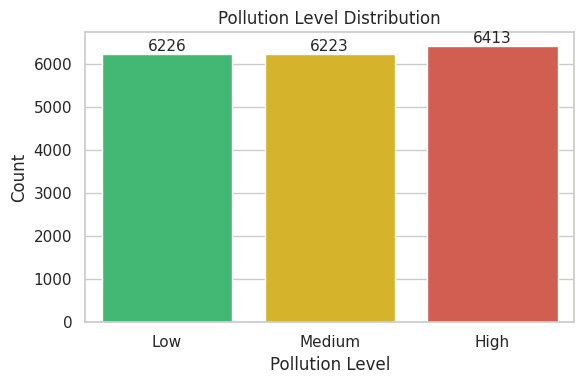

In [21]:
q_low, q_mid = df["Data Value"].quantile([0.33, 0.66])
df["Pollution_Level"] = df["Data Value"].apply(
    lambda v: "Low" if v <= q_low else ("Medium" if v <= q_mid else "High")
)
plt.figure(figsize=(6,4))
colors = ["#2ecc71", "#f1c40f", "#e74c3c"]
ax = sns.countplot(
    x=df["Pollution_Level"],
    order=["Low", "Medium", "High"],
    palette=colors
)
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height(),
        int(p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
    )
plt.title("Pollution Level Distribution")
plt.xlabel("Pollution Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Preparing features, removing unused columns, separating target, and identifying feature types.

In [22]:
target_col = "Pollution_Level"
cols_to_drop = [
    "Unique ID",
    "Start_Date",
    "Name_wrapped"
]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
X = df.drop(columns=[target_col] + cols_to_drop)
y = df[target_col]
print("Feature columns:", X.columns.tolist())
print("\nTarget:", target_col)
cat_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
print("Categorical features:", cat_features)
print("Numeric features:", num_features)

Feature columns: ['Indicator ID', 'Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period', 'Data Value', 'Year', 'Month', 'Day', 'Weekday', 'Is_Weekend', 'Season']

Target: Pollution_Level
Categorical features: ['Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Place Name', 'Time Period', 'Is_Weekend', 'Season']
Numeric features: ['Indicator ID', 'Geo Join ID', 'Data Value', 'Year', 'Month', 'Day', 'Weekday']


Creating stratified train-test split and preparing features with transformer pipeline.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain class distribution:")
print(y_train.value_counts(normalize=True))

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", min_frequency=10)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

Train shape: (15089, 15) Test shape: (3773, 15)

Train class distribution:
Pollution_Level
High      0.339983
Low       0.330108
Medium    0.329909
Name: proportion, dtype: float64


Evaluating classifier performance, printing metrics, and visualizing confusion matrix results.

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
def evaluate_classifier(model, X_train, y_train, X_test, y_test, labels, title_suffix="", cmap="Blues"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec  = recall_score(y_test, y_pred, average='weighted')
    print(f"\n{title_suffix}")
    print("Accuracy :", acc)
    print("F1 Score :", f1)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        annot_kws={"size": 14, "weight": "bold"},
        cbar=False,
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f"Confusion Matrix - {title_suffix}", fontsize=16, weight="bold")
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    return acc, f1, prec, rec

Building logistic regression pipeline, training model, and evaluating pollution classification.


Logistic Regression
Accuracy : 0.9833024118738405
F1 Score : 0.9833067406630212
Precision: 0.9833398432176582
Recall   : 0.9833024118738405

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.99      0.99      1283
         Low       0.98      0.99      0.98      1245
      Medium       0.98      0.97      0.97      1245

    accuracy                           0.98      3773
   macro avg       0.98      0.98      0.98      3773
weighted avg       0.98      0.98      0.98      3773



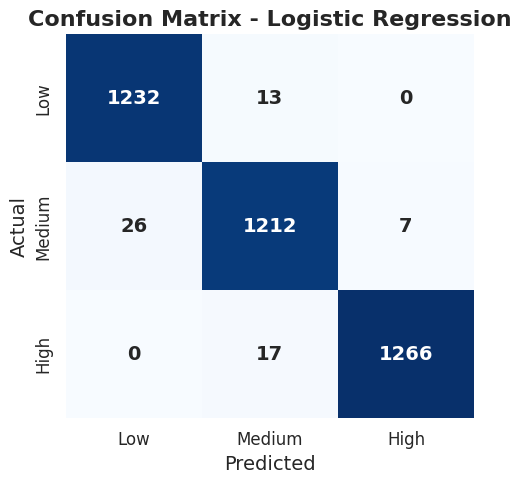

In [25]:
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])
acc_lr, f1_lr, prec_lr, rec_lr = evaluate_classifier(
    log_reg_clf,
    X_train, y_train,
    X_test, y_test,
    labels=["Low","Medium","High"],
    title_suffix="Logistic Regression",
    cmap="Blues"
)

Building SVM classifier with RBF kernel and evaluating pollution categories.


SVM (RBF)
Accuracy : 0.9591836734693877
F1 Score : 0.9592776701491849
Precision: 0.9594460185936551
Recall   : 0.9591836734693877

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.97      0.98      1283
         Low       0.95      0.96      0.96      1245
      Medium       0.93      0.94      0.94      1245

    accuracy                           0.96      3773
   macro avg       0.96      0.96      0.96      3773
weighted avg       0.96      0.96      0.96      3773



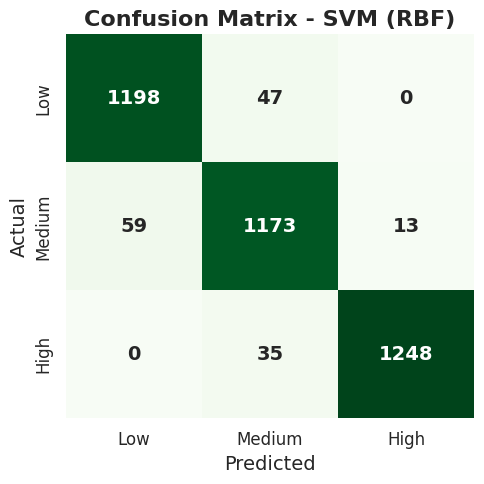

In [26]:
svc_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])
acc_svc, f1_svc, prec_svc, rec_svc = evaluate_classifier(
    svc_clf,
    X_train, y_train,
    X_test, y_test,
    labels=["Low","Medium","High"],
    title_suffix="SVM (RBF)",
    cmap="Greens"
)

Applying SMOTE, tuning KNN hyperparameters via grid search, and visualizing confusion matrix.

Best KNN params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
Best CV accuracy: 0.9664657115963989

Optimized KNN
Test Accuracy: 0.9756162205141797
F1 Score: 0.9756161780888497
Precision: 0.9756225242603307
Recall: 0.9756162205141797

Classification Report:
               precision    recall  f1-score   support

        High       0.99      0.98      0.98      1283
         Low       0.98      0.98      0.98      1245
      Medium       0.96      0.96      0.96      1245

    accuracy                           0.98      3773
   macro avg       0.98      0.98      0.98      3773
weighted avg       0.98      0.98      0.98      3773



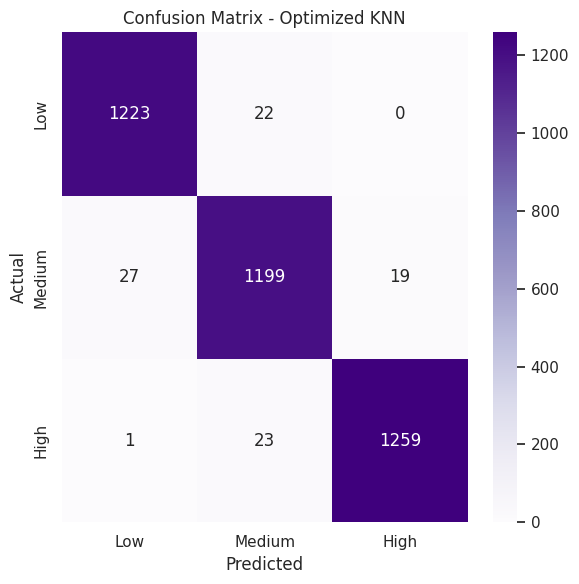

In [27]:
knn_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", KNeighborsClassifier())
])
param_grid = {
    "clf__n_neighbors": [3, 5, 7, 9],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_knn = GridSearchCV(
    knn_pipeline,
    param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
print("Best KNN params:", grid_knn.best_params_)
print("Best CV accuracy:", grid_knn.best_score_)
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
prec_knn = precision_score(y_test, y_pred_knn, average='weighted')
rec_knn = recall_score(y_test, y_pred_knn, average='weighted')
print("\nOptimized KNN")
print("Test Accuracy:", acc_knn)
print("F1 Score:", f1_knn)
print("Precision:", prec_knn)
print("Recall:", rec_knn)

print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=["Low","Medium","High"])
plt.figure(figsize=(6,6))
sns.heatmap(cm_knn, annot=True, fmt="d",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"],
            cmap="Purples")
plt.title("Confusion Matrix - Optimized KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Comparing model performance by plotting accuracy scores for each classifier.

In [35]:
results_df = pd.DataFrame({
    "Model": ["LogReg", "SVM", "KNN"],
    "Accuracy": [acc_lr, acc_svc, acc_knn],
    "F1 Score": [f1_lr, f1_svc, f1_knn]
})
fig = go.Figure()
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["Accuracy"],
    name="Accuracy",
    marker_color="#6a4c93"
))
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["F1 Score"],
    name="F1 Score",
    marker_color="#f39c12"
))
fig.update_layout(
    title="Model Performance Comparison (Accuracy vs F1 Score)",
    xaxis_title="Models",
    yaxis_title="Score",
    yaxis=dict(range=[0, 1], tickformat=".2f"),
    barmode="group",
    bargap=0.3,
    bargroupgap=0.1,
    legend=dict(title="Metrics")
)
fig.show()

Reducing dimensions using PCA and plotting predicted classifications against actual labels.

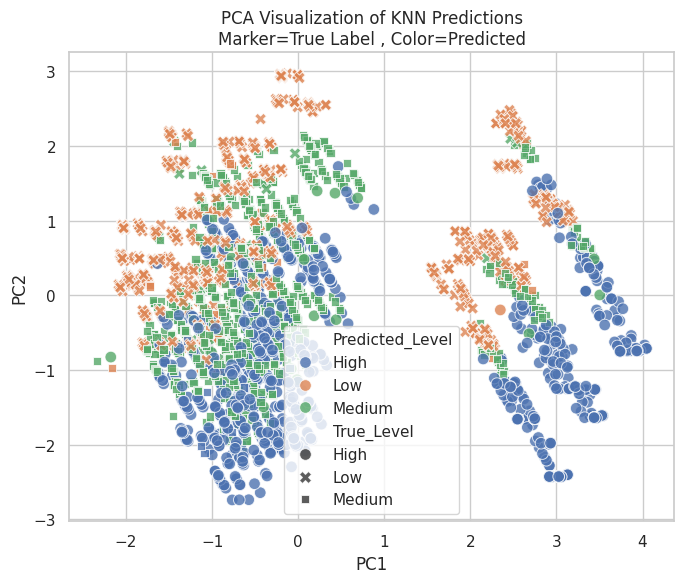

PCA Variance Explained: [0.195 0.111]


In [36]:
preprocessor_knn = best_knn.named_steps["preprocess"]
X_train_t = preprocessor_knn.transform(X_train)
X_test_t = preprocessor_knn.transform(X_test)
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_t)
X_test_pca = pca.transform(X_test_t)
pca_df = pd.DataFrame({
    "PC1": X_test_pca[:,0],
    "PC2": X_test_pca[:,1],
    "True_Level": y_test.values,
    "Predicted_Level": y_pred_knn
})
plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Predicted_Level", style="True_Level", s=70, alpha=0.8)
plt.title("PCA Visualization of KNN Predictions\nMarker=True Label , Color=Predicted")
plt.tight_layout()
plt.show()
print("PCA Variance Explained:", pca.explained_variance_ratio_.round(3))

Identifying misclassified samples using PCA plot and displaying their details.

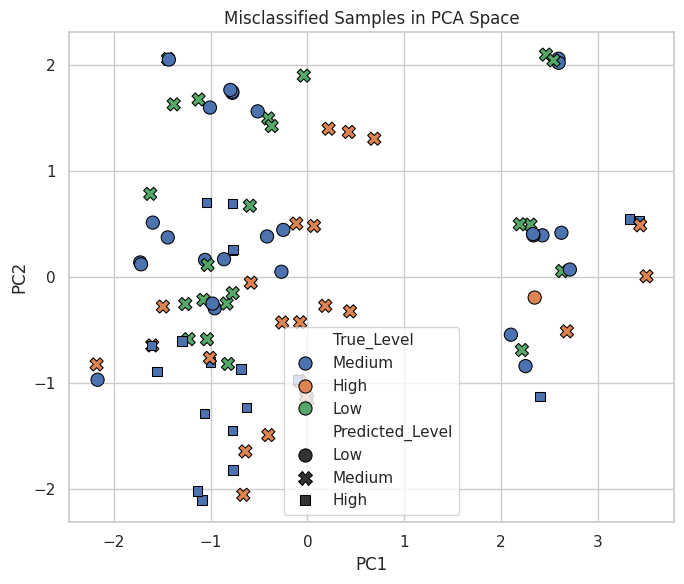

Misclassified Samples: 


,PC1,PC2,True_Level,Predicted_Level
41,2.102037,-0.546796,Medium,Low
70,2.427542,0.390497,Medium,Low
100,-0.114478,0.501596,High,Medium
168,2.347664,-0.196434,High,Low
187,-0.772895,-1.448489,Medium,High


In [37]:
mis_df = pca_df[pca_df["True_Level"] != pca_df["Predicted_Level"]]
plt.figure(figsize=(7,6))
sns.scatterplot(data=mis_df, x="PC1", y="PC2", hue="True_Level", style="Predicted_Level",
                s=90, edgecolor="black")
plt.title("Misclassified Samples in PCA Space")
plt.tight_layout()
plt.show()
print("Misclassified Samples: ")
display(mis_df.head())

Binarizing labels and computing macro ROC-AUC for multi-class evaluation and Applying cross-validation to measure accuracy consistency and compute mean performance.

In [38]:
classes = ["Low","Medium","High"]
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_knn.predict_proba(X_test)
auc_score = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
print("Multi-Class ROC-AUC:", auc_score)

cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Std Dev:", cv_scores.std())

Multi-Class ROC-AUC: 0.25313801746280223
